In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import urllib
import io
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Loading Garfields

In [2]:
# The urls where the Garfield images can be found
urls = ['https://i.ibb.co/4jQ5vvf/garfield-cropped-transparent.png',
       'https://i.ibb.co/BfJNCkW/garfield3-removebg-preview.png',
       'https://i.ibb.co/GMhtZgx/garfield5-removebg-preview.png',
       'https://i.ibb.co/XXkJdjB/garfield6-removebg-preview.png',
       'https://i.ibb.co/HNgsyNc/garfield7.png']

In [3]:
# Fuction for reading the Garfield images from a url, resizing them to 28x28, converting to black and white, and then to a NumPy array
def read(url):
    # Reading the file from a url and opening it as an Image object using PIL
    garfield_file = urllib.request.urlopen(url)
    garfield_file = io.BytesIO(garfield_file.read())
    garfield = Image.open(garfield_file)
    # Resizing the image to 28x28 pixels and converting to black and white
    garfield = garfield.resize((28,28))
    garfield = garfield.convert('L')
    # Converting the PIL Image to a NumPy array
    garfield = np.array(garfield)
    return garfield

In [4]:
# Loading the Garfields
garfields = [read(url) for url in urls]
garfields = np.transpose(np.array(garfields), (1,2,0))
# For each Garfield, also include flipped and rotated copies to increase the size of our basis
for augmentation in [np.rot90(garfields), np.rot90(garfields, 2), np.rot90(garfields, 3), np.flipud(garfields), np.fliplr(garfields)]:
    garfields = np.append(garfields, augmentation, axis=2)
# Reshaping the Garfields into the matrix shape we need for least squares
garfields = np.transpose(garfields, (2,0,1))
garfields = garfields.reshape((30,784))
garfields = garfields.T

# Loading MNIST Data

In [5]:
mnist = fetch_openml('mnist_784')

In [6]:
mnist_array = np.array(mnist.data)

In [7]:
mnist_array = mnist_array.reshape((70000, 28 * 28))

In [8]:
mnist_labels = np.array(mnist.target, dtype='int32')

### Splitting into Training and Testing Sets

In [9]:
x_train, x_test, y_train, y_test = train_test_split(mnist_array, mnist_labels)

# Dimensionality Reduction Using Garfields

Idea: We will extract 30 features to use for classification with an SVM. To obtain these features, we use least squares to approximately solve the equation $G\vec{x}=\vec{d}$, where $G$ is the matrix of vectorized Garfield images and $\vec{d}$ is the vectorized digit image. The 30 entries of the approximate solution, $\vec{x}$, are what we will use as the features for classification.

In [11]:
num_garfields = garfields.shape[1]

In [12]:
# Initializing arrays for our transformed data
transformed_x_train = np.zeros((len(x_train), num_garfields))
transformed_x_test = np.zeros((len(x_test), num_garfields))

### Extracting Features in the Garfield Basis Using Least Squares

In [13]:
for i, image in enumerate(x_train):
    transformed_x_train[i,:] = np.linalg.lstsq(garfields, image)[0]

<ipython-input-13-c29550df7b8d>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  transformed_x_train[i,:] = np.linalg.lstsq(garfields, image)[0]


In [14]:
for i, image in enumerate(x_test):
    transformed_x_test[i,:] = np.linalg.lstsq(garfields, image)[0] 

<ipython-input-14-f3bd952a7578>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  transformed_x_test[i,:] = np.linalg.lstsq(garfields, image)[0]


### Performing Classification

We will now use our extracted features for classification with an SVM.

In [15]:
clf = SVC() # Initializing an SVM

In [16]:
clf.fit(transformed_x_train, y_train) # Fitting the SVM using our extracted feature set

SVC()

In [17]:
preds = clf.predict(transformed_x_test) # Making predictions

In [44]:
# Printing out performance metrics
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1719
           1       0.98      0.99      0.99      2022
           2       0.96      0.97      0.97      1708
           3       0.96      0.93      0.95      1827
           4       0.96      0.96      0.96      1701
           5       0.95      0.95      0.95      1641
           6       0.97      0.98      0.98      1730
           7       0.96      0.96      0.96      1760
           8       0.95      0.94      0.94      1717
           9       0.94      0.94      0.94      1675

    accuracy                           0.96     17500
   macro avg       0.96      0.96      0.96     17500
weighted avg       0.96      0.96      0.96     17500

[[1696    0    3    3    1    2    5    0    9    0]
 [   0 1996    5    2    2    3    2    3    4    5]
 [   6    3 1662    8    7    3    3    5    9    2]
 [   3    6   26 1707    1   36    5   12   27    4]
 [   3    2    7    1 1632   

The SVM trained using the Garfield features attains a surprising 96% accuracy. This is much higher than I was expecting, and certainly demonstrates the power of SVMs for separating data, even when the features are somewhat questionably obtained.

### Displaying Representation of Digits in the Garfield Basis

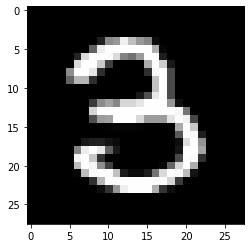

In [45]:
# Image from the testing set
plt.imshow(x_test[0].reshape(28,28), cmap='gray')

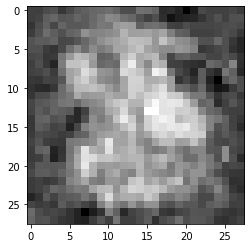

In [46]:
# The same image represented as a linear combination of Garfields
plt.imshow((garfields@transformed_x_test[0]).reshape(28,28), cmap='gray')

# Performing Normal PCA

What if instead of using images of Garfield, we extracted features using Principal Component Analysis?

In [21]:
pca = PCA(n_components=30) # Instantiating PCA Model

In [22]:
pca.fit(x_train) # Extracting PCA components from the training set

PCA(n_components=30)

In [23]:
# Transforming the training and testing data
pca_x_train = pca.transform(x_train)
pca_x_test = pca.transform(x_test)

In [24]:
pca_clf = SVC() # New SVM for use with the PCA components

In [25]:
pca_clf.fit(pca_x_train, y_train) # Fitting SVM on the PCA features

SVC()

In [26]:
pca_preds = pca_clf.predict(pca_x_test) # Making predictions

In [27]:
# Printing out performance metrics
print(classification_report(y_test, pca_preds))
print(confusion_matrix(y_test, pca_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1719
           1       0.99      0.99      0.99      2022
           2       0.98      0.98      0.98      1708
           3       0.99      0.97      0.98      1827
           4       0.98      0.98      0.98      1701
           5       0.98      0.98      0.98      1641
           6       0.99      0.99      0.99      1730
           7       0.98      0.98      0.98      1760
           8       0.98      0.98      0.98      1717
           9       0.97      0.97      0.97      1675

    accuracy                           0.98     17500
   macro avg       0.98      0.98      0.98     17500
weighted avg       0.98      0.98      0.98     17500

[[1711    0    1    0    0    2    1    0    3    1]
 [   1 2004    7    1    1    0    1    2    2    3]
 [   3    1 1682    1    4    0    0    9    8    0]
 [   0    3   11 1771    0   13    0    8   11   10]
 [   1    0    3    0 1665   

We can see that the SVM with 30 PCA components achieves essentially the same performance as the model trained on the original data. However, it is still remarkable that this is only 2% more accurate than using Garfields.

### Displaying Representation of Digits in the Principal Components Basis

Qualitatively, we can see that the PCA basis is able to much better represent the digit than the Garfield basis.

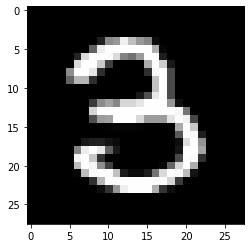

In [43]:
plt.imshow(x_test[0].reshape(28,28), cmap='gray')

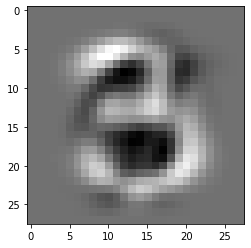

In [100]:
plt.imshow((pca.components_.T@pca_x_test[0]).reshape(28,28), cmap='gray')

### Creating Figures for Presentation Showing PCA Components and Garfields

In [28]:
pca_digits = pca.components_.reshape((30,28,28))

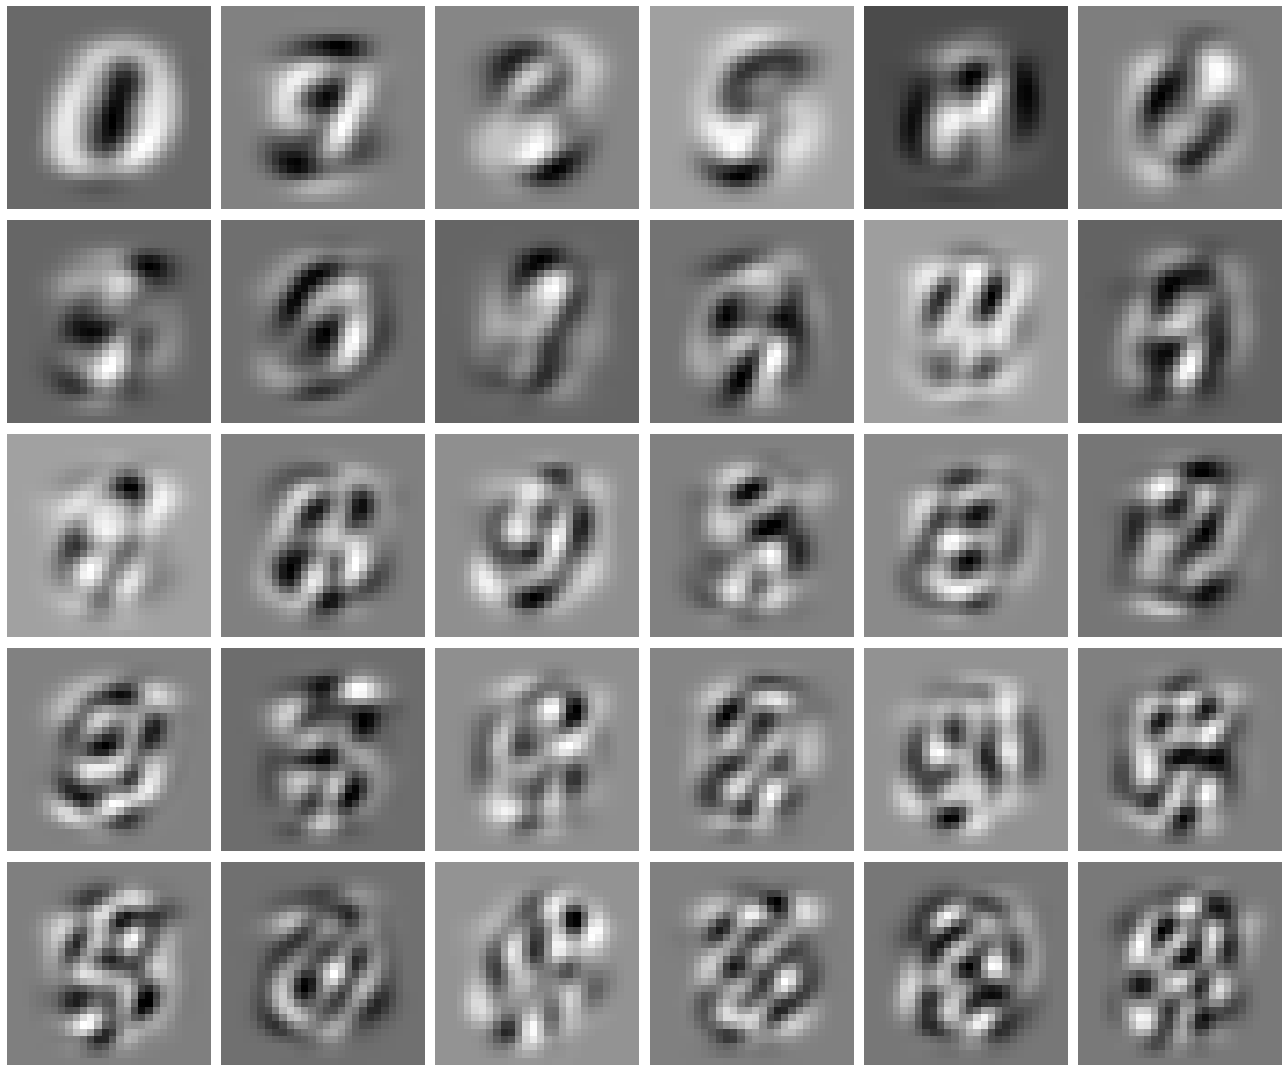

In [29]:
plt.figure(figsize=(18,15))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(pca_digits[i,:,:], cmap='gray')
    plt.axis('off')
    plt.tight_layout()

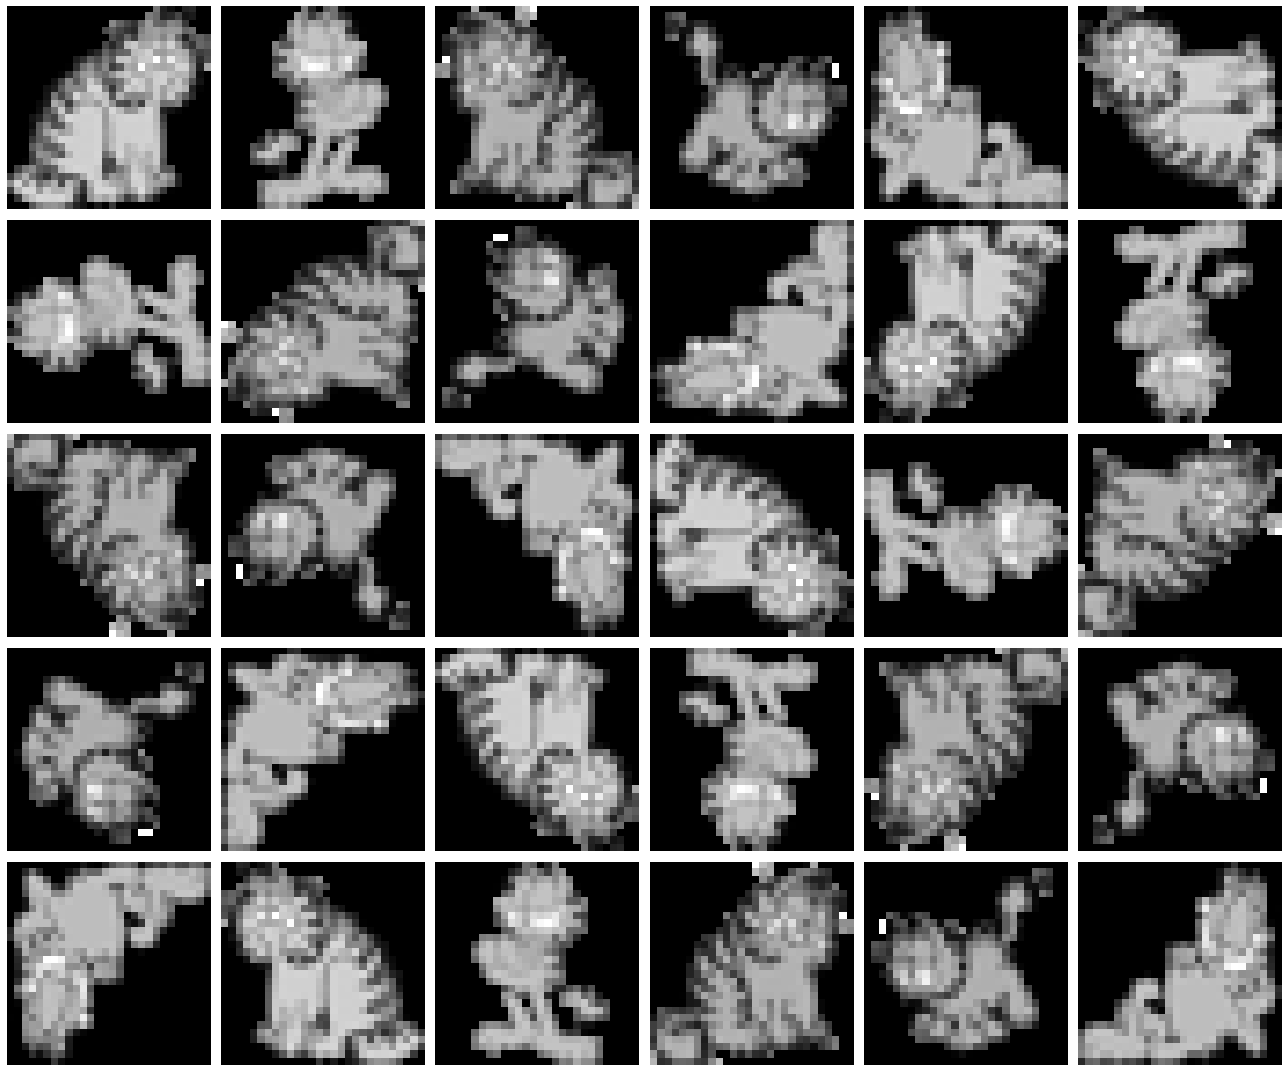

In [30]:
plt.figure(figsize=(18,15))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(garfields[:,i].reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.tight_layout()